In [1]:
!pip install -U langgraph
!pip install --upgrade langchain-openai
!pip install --upgrade langchain-anthropic langchain-core langchain-community

/bin/bash: /home/koiti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached langgraph-0.4.8-py3-none-any.whl.metadata (6.8 kB)
  Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl.metadata (4.5 kB)
  Using cached langgraph_sdk-0.1.70-py3-none-any.whl.metadata (1.5 kB)
  Using cached ormsgpack-1.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (43 kB)
Using cached langgraph-0.4.8-py3-none-any.whl (152 kB)
Using cached langgraph_prebuilt-0.2.2-py3-none-any.whl (23 kB)
Using cached langgraph_sdk-0.1.70-py3-none-any.whl (49 kB)
Using cached ormsgpack-1.10.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (216 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [langgraph]
/bin/bash: /home/koiti/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
  Using cached langchain_core-0.3.65-py3-none-any.whl.metadata (5.8 kB)
Using cached langchain_core-0.3.65-py3-none-any.whl (43

Etapa 1: Definir o StateGraph

Defina um objeto StateGraph para estruturar o chatbot como uma máquina de estado. O State é um objeto de classe definido com uma única chave messages do tipo List e usa a função add_messages() para anexar novas mensagens em vez de sobrescrevê-las.

In [2]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
class State(TypedDict):
    # messages have the type "list".
    # The add_messages function appends messages to the list, rather than overwriting them
    messages: Annotated[list, add_messages]
graph_builder = StateGraph(State)

Etapa 2: Inicialize um LLM e adicione-o como um nó do Chatbot

Aqui, inicializamos o modelo AzureChatOpenAI e criamos uma função simples de chatbot que recebe as mensagens de estado como entrada e gera uma resposta de mensagem (que é posteriormente anexada ao estado).

Essa função de chatbot é adicionada ao gráfico como um nó chamado "chatbot".

In [5]:
from typing import TypedDict, Annotated
from typing_extensions import TypedDict       # se estiver usando Python<3.12
from langgraph.graph.message import add_messages
from langchain_core.messages import BaseMessage
from langgraph.graph import StateGraph, START

class ChatState(TypedDict):
    messages: Annotated[list[BaseMessage], add_messages]
    # exemplo de campo adicional
    topic: str

workflow = StateGraph(state_schema=ChatState)

def chatbot(state: ChatState):
    response = llm.invoke(state["messages"])
    return {
        "messages": [response],
        # podemos alterar outros campos se quiser
    }

workflow.add_node("chatbot", chatbot)
workflow.add_edge(START, "chatbot")
app = workflow.compile()


Se você precisa de campos extras além de messages, defina um TypedDict e use o utilitário add_messages para que o LangGraph saiba mesclar listas de mensagens:

In [6]:
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI
from langgraph.graph import StateGraph, MessagesState, START
from langchain_core.messages import HumanMessage

load_dotenv()   # lê OPENAI_API_KEY

llm = ChatOpenAI(model_name="gpt-3.5-turbo", temperature=0.7)

# ── grafo mínimo ─────────────────────────────────────────────
workflow = StateGraph(state_schema=MessagesState)

def call_model(state: MessagesState):
    response = llm.invoke(state["messages"])
    # devolve atualização de estado ⟶ adiciona a resposta na lista
    return {"messages": [response]}

workflow.add_node("chatbot", call_model)
workflow.add_edge(START, "chatbot")        # 1º passo
app = workflow.compile()                   # usa checkpointer in-memory por padrão

# invocação de teste
out = app.invoke({"messages": [HumanMessage("Quem escreveu a UDHR?")]},
                 config={"configurable": {"thread_id": "thread-1"}})

print(out["messages"][-1].content)

A Declaração Universal dos Direitos Humanos foi escrita por uma comissão liderada por Eleanor Roosevelt e adotada pela Assembleia Geral das Nações Unidas em 1948.


Etapa 3: Definir bordas

Como estamos criando um chatbot simples, definimos o nó chatbot como os pontos de entrada e de saída do gráfico para indicar onde iniciar e terminar o processo.

In [26]:
# Set entry and finish points
graph_builder.set_entry_point("chatbot")
graph_builder.set_finish_point("chatbot")

Etapa 4: Compilar e visualizar o gráfico

Compile o gráfico para criar um CompiledGraph e, opcionalmente, podemos visualizar a estrutura do gráfico usando o código abaixo:

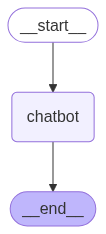

In [27]:
graph = graph_builder.compile()
from IPython.display import Image, display
try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    pass

Etapa 5: Execute o chatbot

Por fim, implementamos um loop para solicitar continuamente a entrada do usuário, processá-la por meio do gráfico e imprimir a resposta do assistente. O loop é encerrado quando o usuário digita "quit", "exit", ou "q".

In [28]:
# Run the chatbot
while True:
    user_input = input("User: ")
    if user_input.lower() in ["quit", "exit", "q"]:
        print("Goodbye!")
        break
    for event in graph.stream({"messages": [("user", user_input)]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Assistant: A capital da França é Paris.
Assistant: Olá! Como posso ajudar você hoje?
Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?
Assistant: Hello! How can I assist you today?


KeyboardInterrupt: Interrupted by user

Tipos de nós personalizados

O LangGraph permite que você crie tipos de nós personalizados para implementar uma lógica de agente complexa. Isso proporciona flexibilidade e controle sobre o comportamento do seu aplicativo.

In [31]:
from typing import Annotated
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages
class MyCustomNode:
    def __init__(self, llm):
        self.llm = llm
    def __call__(self, state):
        # Implement your custom logic here
        # Access the state and perform actions
        messages = state["messages"]
        response = self.llm.invoke(messages)
        return {"messages": [response]}
graph_builder = StateGraph(State)
llm = ChatAnthropic(model="gpt-3.5-turbo")
custom_node = MyCustomNode(llm)
graph_builder.add_node("custom_node", custom_node)

Tipos de borda

O LangGraph oferece suporte a diferentes tipos de borda para lidar com vários padrões de comunicação entre os nós. Um tipo útil é a borda condicional, que permite a tomada de decisões com base na saída de um nó.

Para criar uma borda condicional, você precisa de três componentes:

    O nó upstream: A saída do nó decide a próxima etapa.
    Uma função: Essa função avalia a saída do nó upstream e determina o próximo nó a ser executado, retornando uma cadeia de caracteres que representa a decisão.
    Um mapeamento: Esse mapeamento vincula os possíveis resultados da função aos nós correspondentes a serem executados.
    Aqui está um exemplo em pseudocódigo:

graph.add_conditional_edge(
    "model",
    should_continue,
    {
        "end": END,
        "continue": "tools"
    }
)

Gerenciamento do estado

O LangGraph oferece técnicas avançadas de gerenciamento de estado, que incluem o uso de bancos de dados externos, como SQLite, PostgreSQL e MongoDB, ou soluções de armazenamento em nuvem, como Amazon S3, Google Cloud Storage e Azure Blob Storage, para armazenar e recuperar o estado do seu agente, permitindo confiabilidade e escalabilidade.

Aqui está um exemplo de uso de um banco de dados SQLite para gerenciamento de estado:

In [ ]:
from langgraph.checkpoint.sqlite import SqliteSaver
# Connect to the SQLite database
memory = SqliteSaver.from_conn_string(":memory:")
# Compile the graph with the checkpointer
graph = graph_builder.compile(checkpointer=memory)